# Handwritten Digit Recognition using Neural Networks

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import matplotlib.pyplot as plt

### Softmax Function

In [2]:
def my_softmax(z):  
    """ Softmax converts a vector of values to a probability distribution.
    Args:
      z (ndarray (N,))  : input data, N features
    Returns:
      a (ndarray (N,))  : softmax of z
    """ 
    n = z.shape[0]
    a = np.zeros(n)
    s = np.sum(np.exp(z))
    for i in range(n):
        a[i] = np.exp(z[i])/s
    return a

In [3]:
def load_data():
    X = np.load("data/X.npy")
    y = np.load("data/y.npy")
    return X, y

In [4]:
# load dataset
""" 
The data set contains 5000 training examples of handwritten digits
      1. Each training example is a 20-pixel x 20-pixel grayscale image of the digit.
      2. Each pixel is represented by a floating-point number indicating the grayscale intensity at that location.
      3. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector.
      4. Each training examples becomes a single row in our data matrix X.
      5. This gives us a 5000 x 400 matrix X where every row is a training example of a handwritten digit image.
"""
X, y = load_data()

In [5]:
print ('The first element of X is: ', X[0])


The first element of X is:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

In [6]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  9


In [7]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (5000, 400)
The shape of y is: (5000, 1)


In [8]:
def widgvis(fig):
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    fig.canvas.footer_visible = False

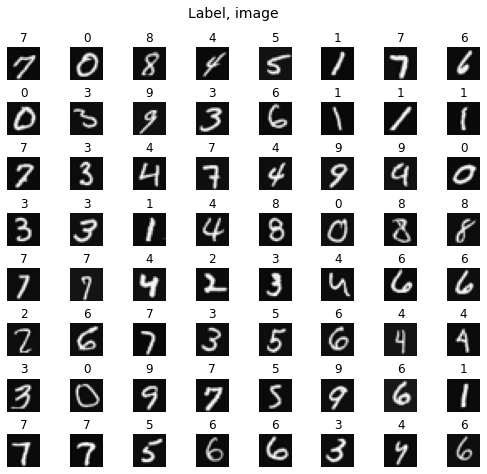

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape
fig, axes = plt.subplots(8,8, figsize=(7,7))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]

widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()
    fig.suptitle("Label, image", fontsize=14)

## Model Representation

We will use the neural network with following architecture
- 1st hidden layer will have 25 neuron. 2nd hidden layer will have 15 neurons and final output layer will have 10 neurons    corresponding to 10 digits.
- Since the images are of size $20\times20$, this gives us $400$ input features.
- ReLu activation function will be used in two hidden layers and then softmax activation will be used in output layer.    

In [10]:
tf.random.set_seed(1234) # for consistent results
model = Sequential(
    [               
        tf.keras.Input(shape=(400,)),
        Dense(units=25, activation="relu", name="L1"),
        Dense(units=15, activation="relu", name="L2"),
        Dense(units=10, activation="linear", name="L3") 
    ], name = "my_model" 
)

In [11]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 25)                10025     
                                                                 
 L2 (Dense)                  (None, 15)                390       
                                                                 
 L3 (Dense)                  (None, 10)                160       
                                                                 
Total params: 10,575
Trainable params: 10,575
Non-trainable params: 0
_________________________________________________________________


In [12]:
[layer1, layer2, layer3] = model.layers

In [13]:
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 10), b3 shape = (10,)


In [14]:
# Adam optimizer is used. 
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    X,y,
    epochs=40
)

Epoch 1/40
157/157 [==============================] - 1s 1ms/step - loss: 1.4959
Epoch 2/40
157/157 [==============================] - 0s 1ms/step - loss: 0.5752
Epoch 3/40
157/157 [==============================] - 0s 1ms/step - loss: 0.3960
Epoch 4/40
157/157 [==============================] - 0s 1ms/step - loss: 0.3190
Epoch 5/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2769
Epoch 6/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2494
Epoch 7/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2231
Epoch 8/40
157/157 [==============================] - 0s 1ms/step - loss: 0.2046
Epoch 9/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1925
Epoch 10/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1704
Epoch 11/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1627
Epoch 12/40
157/157 [==============================] - 0s 1ms/step - loss: 0.1525
Epoch 13/40
157/157 [====

In [15]:
def plot_loss_tf(history):
    fig,ax = plt.subplots(1,1, figsize = (4,3))
    widgvis(fig)
    ax.plot(history.history['loss'], label='loss')
    ax.set_ylim([0, 2])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('loss (cost)')
    ax.legend()
    ax.grid(True)
    plt.show()

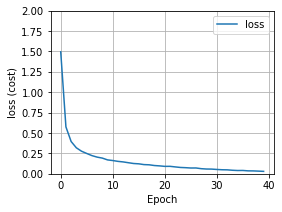

In [16]:
plot_loss_tf(history)

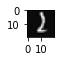

1/1 [==============================] - 0s 65ms/step
 predicting a Two: 
[[ -9.23075     2.9585888   7.0611815   3.5147593 -13.618975  -10.010073
   -3.747712    4.800445   -3.4341035  -5.967779 ]]
 Largest Prediction index: 2


In [17]:
def display_digit(X):
    """ display a single digit. The input is one digit (400,). """
    fig, ax = plt.subplots(1,1, figsize=(0.5,0.5))
    widgvis(fig)
    X_reshaped = X.reshape((20,20)).T
    # Display the image
    ax.imshow(X_reshaped, cmap='gray')
    plt.show()

image_of_two = X[1015]
display_digit(image_of_two)

prediction = model.predict(image_of_two.reshape(1,400))

print(f" predicting a Two: \n{prediction}")
print(f" Largest Prediction index: {np.argmax(prediction)}")

In [18]:
# If we want probabilities than we need to apply softmax to values.
prediction_p = tf.nn.softmax(prediction)

print(f" predicting a Two. Probability vector: \n{prediction_p}")
print(f"Total of predictions: {np.sum(prediction_p):0.3f}")

 predicting a Two. Probability vector: 
[[7.3101575e-08 1.4377695e-02 8.6980623e-01 2.5074420e-02 9.0812280e-10
  3.3532878e-08 1.7586517e-05 9.0697877e-02 2.4064571e-05 1.9099261e-06]]
Total of predictions: 1.000


1/1 [==============================] - 0s 17ms/step


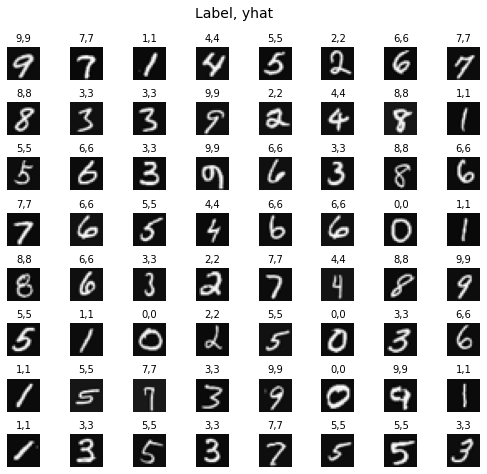

In [19]:
# Try on 64 random samples


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(7,7))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.91]) #[left, bottom, right, top]
widgvis(fig)
for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}",fontsize=10)
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=14)
plt.show()

In [20]:
correct_predictions = 0
pred = []
incorrect_pred = []
for i in range(m):
    prediction = model.predict(X[i].reshape(1,400))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)
    pred.append(yhat)
    if yhat == y[i][0]:
        correct_predictions += 1
    else:
        incorrect_pred.append(i)

accuracy = correct_predictions/m


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 13ms/step


In [21]:
print(accuracy*100)

99.46000000000001


#### Wrong predictions

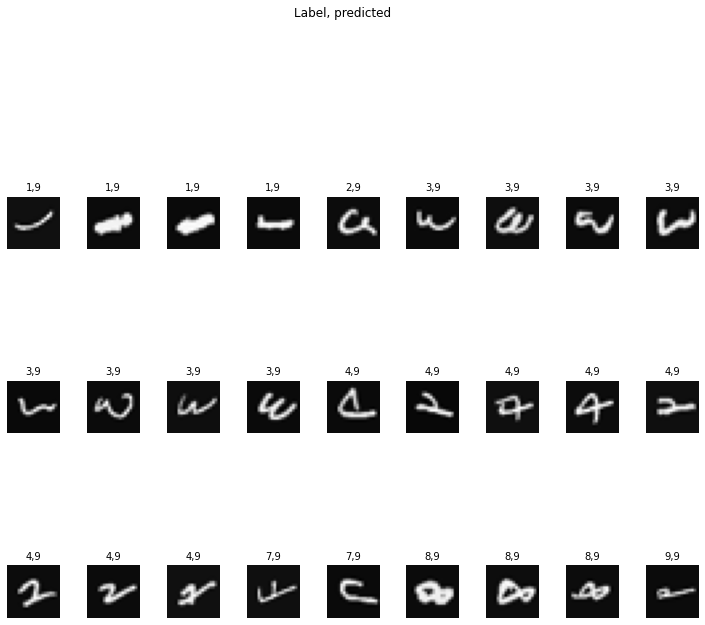

In [42]:
fig, ax = plt.subplots(1,9, figsize=(,10))
fig.tight_layout(pad=0.13,rect=[0, 0.03, 1, 0.80])

for i in range(8):
    j = incorrect_pred[i]
    x = X[j].reshape((20, 20))
    r, c = divmod(i, 9)
    ax[r,c].imshow(x, cmap='gray')
    ax[r,c].set_title(f"{y[j,0]},{yhat}",fontsize=10)
    ax[r,c].set_axis_off()
    fig.suptitle("Label, predicted", fontsize=12)